# Osu taiko playstyle analysis

In [1]:
import os
os.environ['OSUAPIv2_APP_CALLBACK']

'http://localhost:3914/'

In [2]:
# Osu API
from ossapi import *
import os
api = OssapiV2(int(os.environ['OSUAPIv2_APP_ID']), os.environ['OSUAPIv2_APP_SECRET'], os.environ['OSUAPIv2_APP_CALLBACK'])
# apiv1 = Ossapi(os.environ['OSUAPIv1_KEY'])

In [3]:
liemap = api.beatmap(1921771)
print(liemap)

Beatmap(_api=<ossapi.ossapiv2.OssapiV2 object at 0x0000024A2208BB20>, difficulty_rating=6.22, id=1921771, mode=<GameMode.TAIKO: 'taiko'>, status=<RankStatus.LOVED: 4>, total_length=146, version='False', user_id=1980256, beatmapset_id=920188, _beatmapset=Beatmapset(_api=<ossapi.ossapiv2.OssapiV2 object at 0x0000024A2208BB20>, artist='Sakuzyo', artist_unicode='Sakuzyo', covers=Covers(_api=<ossapi.ossapiv2.OssapiV2 object at 0x0000024A2208BB20>, cover='https://assets.ppy.sh/beatmaps/920188/covers/cover.jpg?1622155446', cover_2x='https://assets.ppy.sh/beatmaps/920188/covers/cover@2x.jpg?1622155446', card='https://assets.ppy.sh/beatmaps/920188/covers/card.jpg?1622155446', card_2x='https://assets.ppy.sh/beatmaps/920188/covers/card@2x.jpg?1622155446', list='https://assets.ppy.sh/beatmaps/920188/covers/list.jpg?1622155446', list_2x='https://assets.ppy.sh/beatmaps/920188/covers/list@2x.jpg?1622155446', slimcover='https://assets.ppy.sh/beatmaps/920188/covers/slimcover.jpg?1622155446', slimcover_

In [49]:
# lie = api.beatmap_scores(beatmap_id=1921771, mode="taiko")
# print(lie)

# liev1 = apiv1.get_scores(1921771, mode=1, mods=0, limit=100)
# print(liev1[0].replay_id)
# apiv1.get_replay(beatmap_id = 1921771, user = liev1[0].user_id)

def download_rep(replayID, name = None):
    if name is None:
        name = replayID
    rep = api.session.get(f"{api.BASE_URL}/scores/taiko/{replayID}/download")
    with open(f"replays/{name}.osr", "wb") as f:
        f.write(rep.content)
        
download_rep(168691149)

In [226]:
import numpy as np
from osrparse import parse_replay_file, KeyTaiko

# rep = parse_replay_file("replays/168691149.osr")
# rep = parse_replay_file("replays/Edward_Tsui - Hatsune Miku - Talent Shredder [Firce Force] (2021-12-08) Taiko.osr")
# rep = parse_replay_file("replays/Lubei_01 - antiPLUR - Speed of Link [Special] (2021-10-09) Taiko.osr")
BPM = 149

print(60000 / (BPM * 4)) # 1/4s
print(60000 / (BPM * 2)) # 1/2s
slowThreshold = 60000 / (BPM * 4)

for i in range(4):
    print(f"{i} = {str(KeyTaiko(1 << i))}")

def get_features(rep, slowThreshold):
    
    pressed = KeyTaiko(0)
    timestamp = 0 # Time since previous hit
    prevHit = KeyTaiko(0)

    slow_mat = np.zeros((4,4))
    fast_mat = np.zeros((4,4))

    for hit in rep.play_data:
        newKeys = hit.keys & ~pressed
        pressed = hit.keys
        timestamp += hit.time_delta

        # New hits
        if newKeys != 0:

            # Assign to the array
            prev = np.array([i for i in range(4) if (((1 << i) & prevHit) > 0)], np.int8)
            curr = np.array([i for i in range(4) if (((1 << i) & newKeys) > 0)], np.int8)
            xx, yy = np.meshgrid(prev, curr)

            if timestamp <= slowThreshold:
                fast_mat[xx.flatten(), yy.flatten()] += 1
            else:
                slow_mat[xx.flatten(), yy.flatten()] += 1

            prevHit = newKeys
            timestamp = 0
    
    raw = [fast_mat, slow_mat]
    fast_norm = fast_mat / np.sum(fast_mat)
    slow_norm = slow_mat / np.sum(slow_mat)
    feat = np.stack([fast_norm, slow_norm], axis = 0).astype(np.float64)
#     feat = fast_mat
#     feat = feat / np.sum(feat)
    
    return feat, raw

rep = parse_replay_file("replays/Flandre sca - katagiri - Naopura2000 -Daybreak- [Black Another].osr")
feat, [fast, slow] = get_features(rep, slowThreshold)
print(feat)

print("\nfast:")
print(fast)
print("\nslow:")
print(slow)

100.67114093959732
201.34228187919464
0 = KeyTaiko.LEFT_DON
1 = KeyTaiko.LEFT_KAT
2 = KeyTaiko.RIGHT_DON
3 = KeyTaiko.RIGHT_KAT
[[[0.         0.         0.15789474 0.1130031 ]
  [0.02321981 0.         0.125387   0.14396285]
  [0.03869969 0.21517028 0.         0.        ]
  [0.1130031  0.04798762 0.02167183 0.        ]]

 [[0.03501094 0.03501094 0.07439825 0.03938731]
  [0.10065646 0.01750547 0.12472648 0.07658643]
  [0.05689278 0.21444201 0.         0.00218818]
  [0.12691466 0.09628009 0.         0.        ]]]

fast:
[[  0.   0. 102.  73.]
 [ 15.   0.  81.  93.]
 [ 25. 139.   0.   0.]
 [ 73.  31.  14.   0.]]

slow:
[[16. 16. 34. 18.]
 [46.  8. 57. 35.]
 [26. 98.  0.  1.]
 [58. 44.  0.  0.]]


In [171]:
import time

# Collect replays
TargetPlayers = [
#     1558839, # betairylia
#     11692528,# Lubei
#     6764344, # Nepoch
#     10324309,# Flandre sca
#     8609627, # Edward
#     10507557,# Hynix
#     3383404, # Rin
#     2221895, # Wonberman
#     12208924,# OvO
#     6443264, # acst
#     9603470, # Yusyou
#     4314222, # Kafuu Cirno
#     609536,  # lzx
    
#     2349769, # kk
#     4315477, # sSSS
#     5310623, # Blastix
#     6294200, # te
#     2073644, # Risona
#     810813,  # HM
    6844521, # szh134
    9383908, # shoucan
    4112195, # 7j
    12480076,# Michael
    11341131,# NaNa
    8263525, # smf
    81972,   # Mic
    15917084,# Apricot L
    12703319,# Minato
    12749779,# Lilia Angel
    16903694,# Pinkiemane
    
    8741695, # syaron
    983349,  # applerss
    6170507, # yu68
    5321719, # uone
    165027,  # Peaceful
    1152851, # Bamgoe
    9912966, # Zeth
    9503098, # hoku
    9864847, # Botched
    7955738, # CL
    13302996,# Boaz
    2865172, # Bries
    11117835,# Quass
    9856910, # Gamelan
    8772103, # nuku
    7740442, # Spartric
    6632605, # Megafan
    14005209,# aquachan
    12611862,# diamond
    933630,  # fanhoho
    6498810, # Kerasi
    3867109, # Maou
    5054081, # rai
    12248285,# Storm
    10530606,# Neon
    10694200,# KD
    15541593,# Dau
    1751879, # shiroino
    11936599,# Quibby
    8770622, # ITGT
    1100246, # DefiantJ
    
    6177263, # mp kick Kasumi-sama
]

def GrabFromBP(uid, amount):
    print("Grab BP maps from uid %d (%s)" % (uid, api.user(uid).username))
    best = api.user_scores(uid, "best", mode = "taiko")[:amount]
    for b in best:
        scoreid = b.id
#         print(b.user().username)
#         print(b.beatmapset.artist)
#         print(b.beatmap.version)
        download_rep(scoreid, f"{b.user().username} - {b.id}")
        time.sleep(20)

In [172]:
# GrabFromBP(TargetPlayers[0], 1)

# for uid in TargetPlayers:
#     GrabFromBP(uid, 2)

In [209]:
from tqdm.notebook import tqdm

# Collect features for all replays in folder
features = []

for file in tqdm(os.listdir("replays/")):
    if ".osr" in file:
        rep = parse_replay_file(os.path.join("replays/", file))
        feat, [raw_fast, raw_slow] = get_features(rep, slowThreshold)
        features.append((feat, {'Player': rep.player_name, 'fast': raw_fast, 'slow': raw_slow, 'file': file}))
        
print(features)

  0%|          | 0/131 [00:00<?, ?it/s]

[(array([[[0.        , 0.03981481, 0.05277778, 0.23055556],
        [0.04537037, 0.        , 0.09166667, 0.06296296],
        [0.18425926, 0.02037037, 0.        , 0.        ],
        [0.12037037, 0.15092593, 0.00092593, 0.        ]],

       [[0.0028169 , 0.01502347, 0.01502347, 0.01502347],
        [0.00187793, 0.01314554, 0.03943662, 0.02816901],
        [0.00375587, 0.01690141, 0.10892019, 0.24131455],
        [0.00469484, 0.02629108, 0.27511737, 0.19248826]]]), {'Player': '-OvO-', 'fast': array([[  0.,  43.,  57., 249.],
       [ 49.,   0.,  99.,  68.],
       [199.,  22.,   0.,   0.],
       [130., 163.,   1.,   0.]]), 'slow': array([[  3.,  16.,  16.,  16.],
       [  2.,  14.,  42.,  30.],
       [  4.,  18., 116., 257.],
       [  5.,  28., 293., 205.]]), 'file': '-OvO- - Camellia - Fastest Crash [Crash].osr'}), (array([[[0.        , 0.        , 0.04689655, 0.26758621],
        [0.00413793, 0.        , 0.14482759, 0.0262069 ],
        [0.25655172, 0.0262069 , 0.        , 0.001

In [217]:
import umap
import sklearn

reducer = umap.UMAP()
# reducer = sklearn.decomposition.PCA(n_components = 2)

In [218]:
Xs = [f[0].flatten() for f in features]
Ys = [f[1] for f in features]
emb = reducer.fit_transform(Xs)

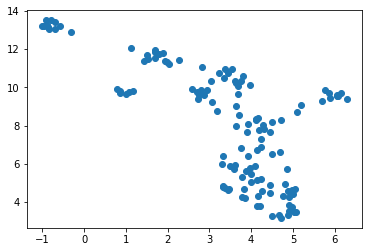

In [219]:
import matplotlib.pyplot as plt

plt.scatter(emb[:, 0], emb[:, 1])

In [220]:
# plotly
import plotly.express as px
import pandas as pd

data = {
    'UMAP-x': emb[:, 0], 
    'UMAP-y': emb[:, 1], 
    'Player': [Y['Player'] for Y in Ys],
    'file': [Y['file'] for Y in Ys],
    'fast': [f"\n{Y['fast']}" for Y in Ys],
    'slow': [f"\n{Y['slow']}" for Y in Ys],
}
df = pd.DataFrame(data)

fig = px.scatter(df, x = 'UMAP-x', y = 'UMAP-y', hover_name = 'Player', hover_data = ['fast', 'slow', 'file'])
fig.show()

In [221]:
import chart_studio.plotly as py
py.plot(fig, filename = 'Taiko playstyle @ umap', auto_open=True)

'https://plotly.com/~betairya/9/'